In [1]:
import pandas as pd
import numpy as np

import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

from uncertainties import unumpy, ufloat

from lmfit.models import Model, PolynomialModel

In [2]:
# https://stackoverflow.com/questions/22348756/upright-mu-in-plot-label-retaining-original-tick-fonts
# https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib

import matplotlib
from matplotlib import rc

matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':'sans-serif'})

params = {'text.latex.preamble':[r'\usepackage{siunitx}',
                                 r'\usepackage{amsmath}',
                                 r'\usepackage{physics}',
                                 r'\usepackage{helvet}',
                                 r'\usepackage{sansmath}',
                                 r'\sansmath',
                                 r'\sisetup{detect-all}']}
plt.rcParams.update(params)

# List of files to read in

In [3]:
# 87Sr data file list
data_list_87Sr = [os.path.join('data-87Sr','18uW_repump_87_repetition_1.00000E+0_11450700_out.csv')]
data_list_87Sr += glob.glob(os.path.join('data-87Sr','18uW_repump_87_2776.043_start*1319*_out.csv'))
data_list_87Sr += glob.glob(os.path.join('data-87Sr','18uW_repump_87_2776.105_start*1405*_out.csv'))
data_list_87Sr += [os.path.join('data-87Sr','18uW_repump_87_2776.145_start_repetition_1.00000E+0_17063200_out.csv')]
data_list_87Sr += glob.glob(os.path.join('data-87Sr','18uW_repump_87_2776.000_start*1727*_out.csv'))
data_list_87Sr += glob.glob(os.path.join('data-87Sr','18uW_repump_87_2776.090_start*1824*_out.csv'))

# 84Sr data file list
data_list_84Sr = glob.glob(os.path.join('data-84Sr','repump_84Sr_20776.054_start*.csv'))

# Reading in .csv files and performing fit to convert from voltage to wavenumber

repump_84Sr_20776.054_start_repetition_1.00000E+0_15500600_out.csv


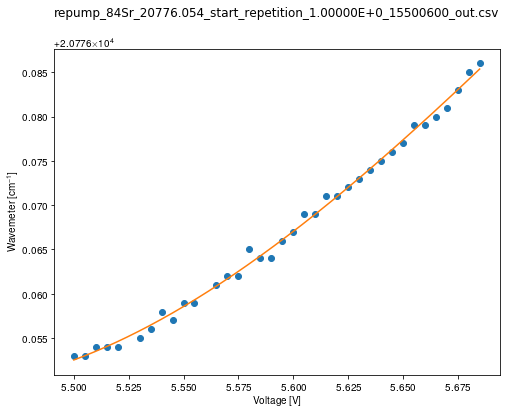

repump_84Sr_20776.054_start_repetition_2.00000E+0_15500601_out.csv


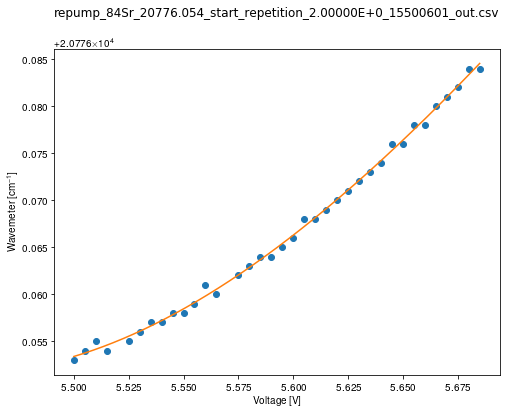

repump_84Sr_20776.054_start_repetition_3.00000E+0_15500602_out.csv


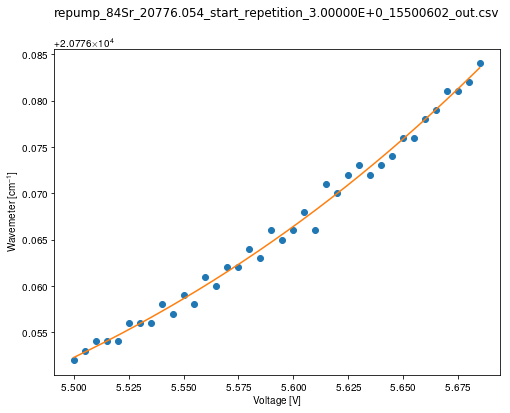

18uW_repump_87_repetition_1.00000E+0_11450700_out.csv


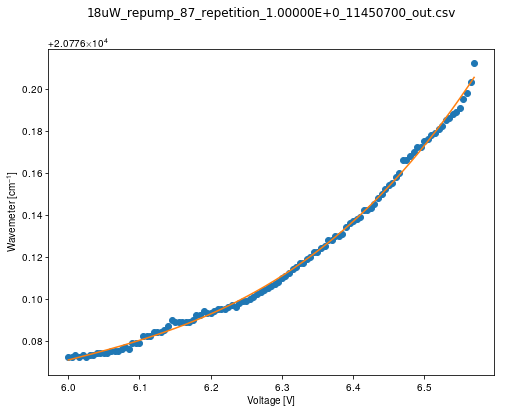

18uW_repump_87_2776.043_start_repetition_1.00000E+0_13193100_out.csv


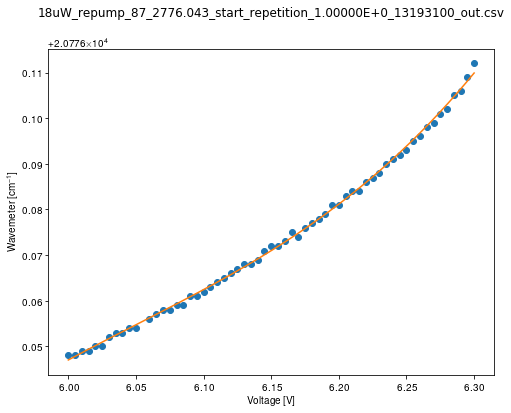

18uW_repump_87_2776.043_start_repetition_2.00000E+0_13193101_out.csv


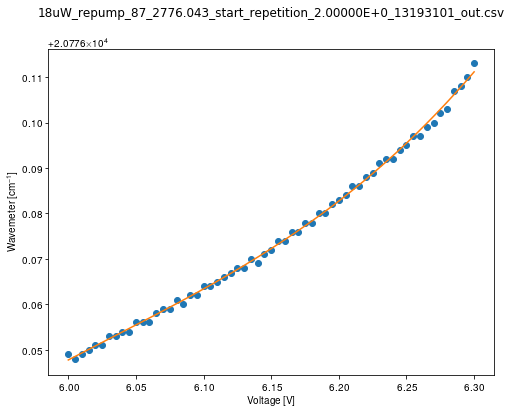

18uW_repump_87_2776.043_start_repetition_3.00000E+0_13193102_out.csv


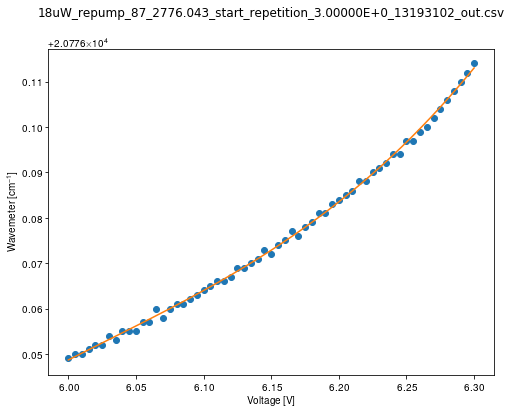

18uW_repump_87_2776.105_start_repetition_1.00000E+0_14050400_out.csv


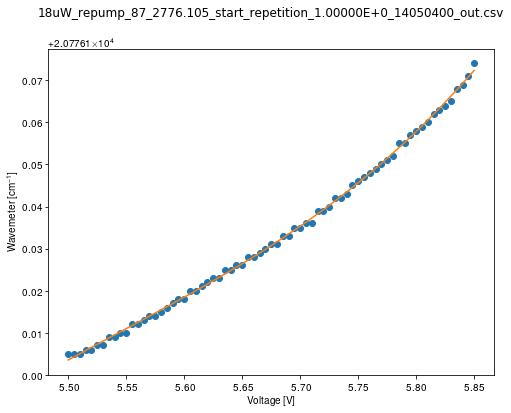

18uW_repump_87_2776.105_start_repetition_2.00000E+0_14050401_out.csv


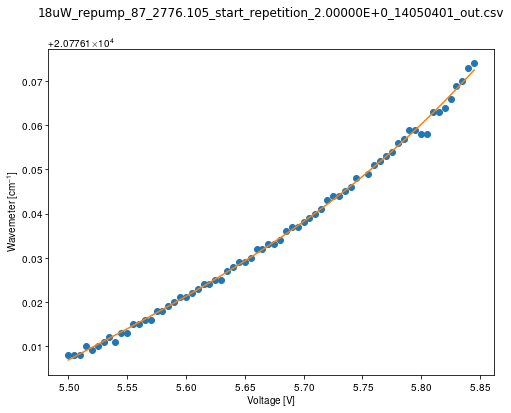

18uW_repump_87_2776.105_start_repetition_3.00000E+0_14050402_out.csv


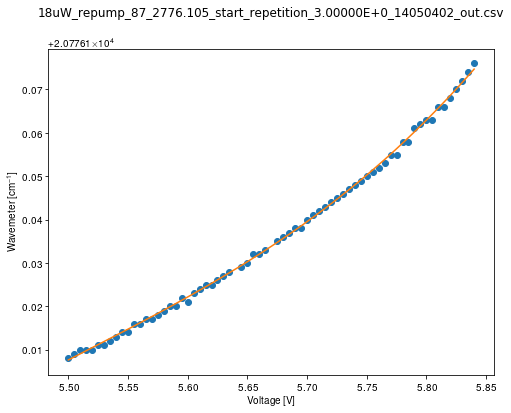

18uW_repump_87_2776.145_start_repetition_1.00000E+0_17063200_out.csv


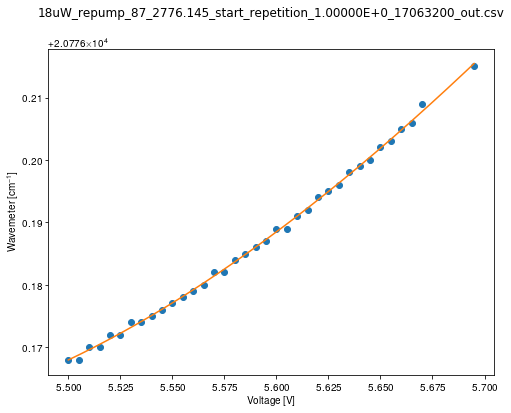

18uW_repump_87_2776.000_start_repetition_1.00000E+0_17272400_out.csv


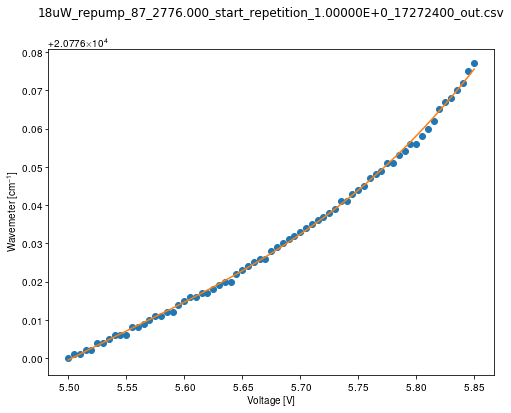

18uW_repump_87_2776.000_start_repetition_2.00000E+0_17272401_out.csv


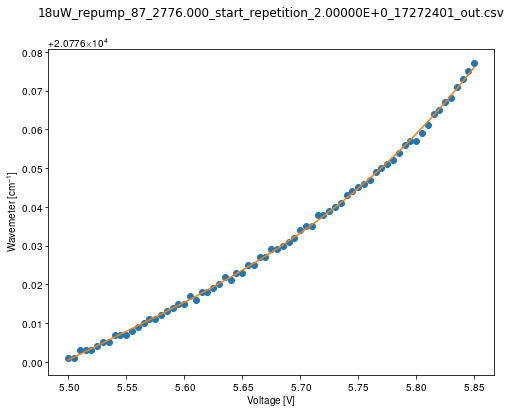

18uW_repump_87_2776.000_start_repetition_3.00000E+0_17272402_out.csv


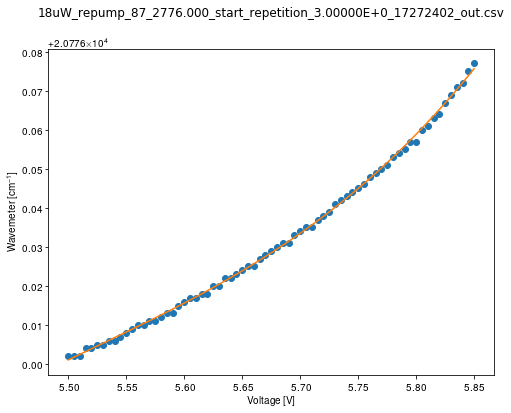

18uW_repump_87_2776.090_start_repetition_1.00000E+0_18242700_out.csv


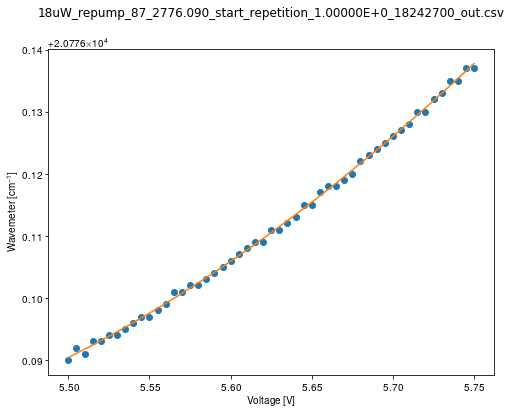

18uW_repump_87_2776.090_start_repetition_2.00000E+0_18242701_out.csv


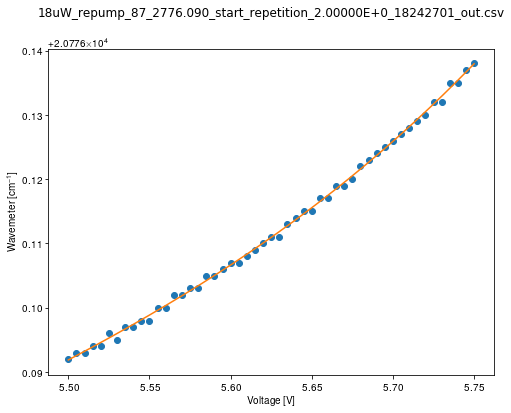

18uW_repump_87_2776.090_start_repetition_3.00000E+0_18242702_out.csv


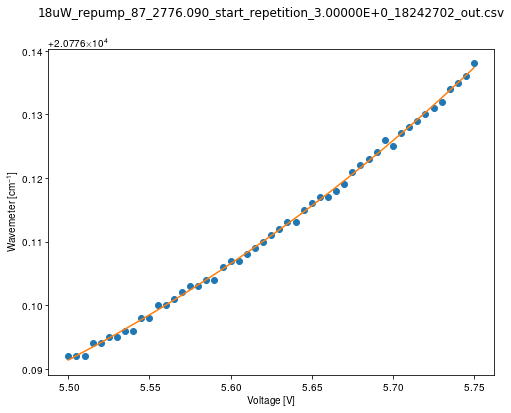

In [4]:
# Fit function to convert voltage to wavemeter
def fit_wavemeter_vs_voltage(xdata, ydata, scan_name):
    
    # Specify fit model
    fit_model = PolynomialModel(degree=3)
    fit_params = fit_model.guess(ydata, x=xdata)
    
    # Initial guess
    xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
    yinit = fit_model.eval(fit_params, x=xfit)
    
    # Fitting
    result = fit_model.fit(ydata, fit_params, x=xdata)
    dely = result.eval_uncertainty(x=xdata)
    yfit = fit_model.eval(result.params, x=xfit)
    
    plt.figure(figsize=(8,6))
    plt.plot(xdata, ydata, 'o', label='data')
    plt.plot(xfit, yfit, label='fit')
    plt.xlabel(r'Voltage [\si{\V}]')
    plt.ylabel(r'Wavemeter [\si{\per\cm}]')
    plt.title(scan_name, y=1.08, usetex=False)
    plt.show()
    
    return fit_model.eval(result.params, x=xdata)

# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    
    for file_name in file_list:
        df = pd.read_csv(file_name)
        scan_name = os.path.basename(file_name)
        df['scan'] = scan_name
        
        print(scan_name)
        
        xdata = df['imagevcoAtom']
        ydata = df['wavemeterAtom']
        df['wavemeter_fit'] = fit_wavemeter_vs_voltage(xdata, ydata, scan_name)
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

data_84Sr = gather_data(data_list_84Sr)
data_87Sr = gather_data(data_list_87Sr)

data_84Sr['wavemeter_fit_shifted'] = data_84Sr['wavemeter_fit']-20776
data_87Sr['wavemeter_fit_shifted'] = data_87Sr['wavemeter_fit']-20776

# Calculate detuning in GHz from 84Sr (centered at 20776.0755). Using 29.9792 cm*GHz conversion
data_84Sr['detuning_from_84Sr'] = (data_84Sr['wavemeter_fit']-20776.0755)*29.9792
data_87Sr['detuning_from_84Sr'] = (data_87Sr['wavemeter_fit']-20776.0755)*29.9792

## Filtering out the "bad" data points based on temperature and atom number

In [5]:
data_87Sr = data_87Sr[(1.5E-6 <= data_87Sr['atomTempY']) & (data_87Sr['atomTempY'] <= 4E-6)]
data_87Sr = data_87Sr[75E3 < data_87Sr['winTotNum']]

data_84Sr = data_84Sr[(0.5E-6 <= data_84Sr['atomTempY']) & (data_84Sr['atomTempY'] <= 2.5E-6)]
data_84Sr = data_84Sr[75E3 < data_84Sr['winTotNum']]

# Making plots

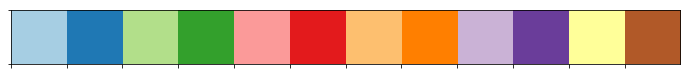

In [6]:
sns.palplot(sns.color_palette("Paired"))

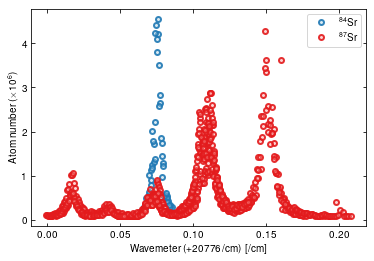

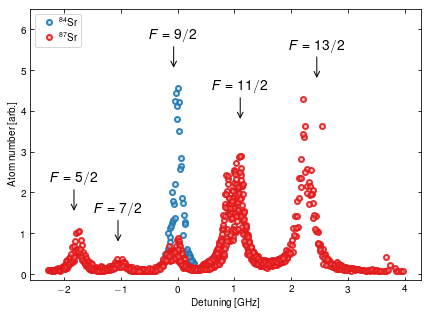

In [7]:
marker_style_84Sr = {'markerfacecolor':sns.color_palette("Paired")[0] + (0.4,),
                     'marker':'o',
                     'markersize':5,
                     'markeredgecolor':sns.color_palette("Paired")[1] + (0.9,),
                     'markeredgewidth':2,
                     'linestyle':'None'}

marker_style_87Sr = {'markerfacecolor':sns.color_palette("Paired")[4] + (0.4,),
                     'marker':'o',
                     'markersize':5,
                     'markeredgecolor':sns.color_palette("Paired")[5] + (0.9,),
                     'markeredgewidth':2,
                     'linestyle':'None'}

plt.figure()
plt.plot(data_84Sr['wavemeter_fit_shifted'], data_84Sr['winTotNum']/1E6,
         **marker_style_84Sr, label=r'$^{84}$Sr')
plt.plot(data_87Sr['wavemeter_fit_shifted'], data_87Sr['winTotNum']/1E6,
         **marker_style_87Sr, label=r'$^{87}$Sr')
plt.xlabel(r'Wavemeter (+20776 /cm) [/cm]')
plt.ylabel(r'Atom number ($\times 10^{6}$)')
plt.gca().tick_params(axis='both', direction='in', top=True, right=True)
plt.legend()
plt.show()

arrowprops={'arrowstyle':'->'}

annotation_args = {'size':14}

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(data_84Sr['detuning_from_84Sr'], data_84Sr['winTotNum']/1E6,
         **marker_style_84Sr, label=r'$^{84}$Sr')
ax.plot(data_87Sr['detuning_from_84Sr'], data_87Sr['winTotNum']/1E6,
         **marker_style_87Sr, label=r'$^{87}$Sr')

Foffset = 0.55
F52 = -2.37122 + Foffset
F72 = -1.59714 + Foffset
F92 = -0.618691 + Foffset
F112 = 0.551517 + Foffset
F132 = 1.89808 + Foffset

ax.annotate(r'$F=5/2$', xy=(F52,1.5), xytext=(F52,2.25), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F=7/2$', xy=(F72,0.75), xytext=(F72,1.5), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F=9/2$', xy=(F92,5), xytext=(F92,5.75), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F=11/2$', xy=(F112,3.75), xytext=(F112,4.5), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F=13/2$', xy=(F132,4.75), xytext=(F132,5.5), ha='center', arrowprops=arrowprops, **annotation_args)

ax.set_xlabel(r'Detuning [GHz]')
#plt.ylabel(r'Atom number ($\times 10^{6}$)')
ax.set_ylabel(r'Atom number [arb.]')
ax.set_ylim(top=6.5)
ax.tick_params(axis='both', direction='in', top=True, right=True)
ax.legend(loc='upper left', handletextpad=0)
plt.savefig('repumper_spectra.pdf', bbox_inches='tight')
plt.show()

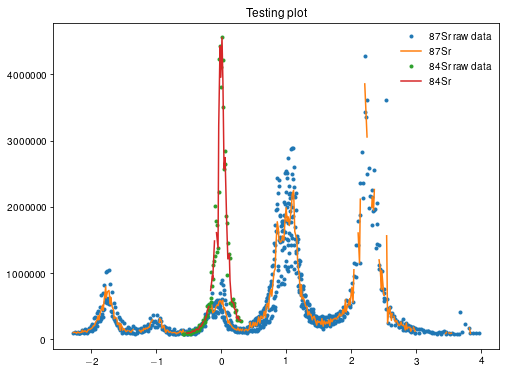

In [8]:
###########################################
# Binning data to appear smoother
# https://www.reddit.com/r/learnpython/comments/73z4e2/pandas_groupby_or_cut_dataframe_to_bins/

plt.figure(figsize=(8,6))

# 87Sr data
bins_87Sr = pd.cut(x=data_87Sr['detuning_from_84Sr'], bins=371)
df_87Sr = data_87Sr.groupby(bins_87Sr)['detuning_from_84Sr','winTotNum'].agg(['mean'])

x_87Sr = df_87Sr['detuning_from_84Sr','mean'].values
y_87Sr = df_87Sr['winTotNum','mean'].values

plt.plot(data_87Sr['detuning_from_84Sr'], data_87Sr['winTotNum'], '.', label=r'87Sr raw data')
plt.plot(x_87Sr, y_87Sr, label=r'87Sr')

# 84Sr data
bins_84Sr = pd.cut(x=data_84Sr['detuning_from_84Sr'], bins=51)
df_84Sr = data_84Sr.groupby(bins_84Sr)['detuning_from_84Sr','winTotNum'].agg(['mean'])

x_84Sr = df_84Sr['detuning_from_84Sr','mean'].values
y_84Sr = df_84Sr['winTotNum','mean'].values

plt.plot(data_84Sr['detuning_from_84Sr'], data_84Sr['winTotNum'], '.', label=r'84Sr raw data')
plt.plot(x_84Sr, y_84Sr, label=r'84Sr')

plt.legend(frameon=False)
plt.title('Testing plot')
plt.show()

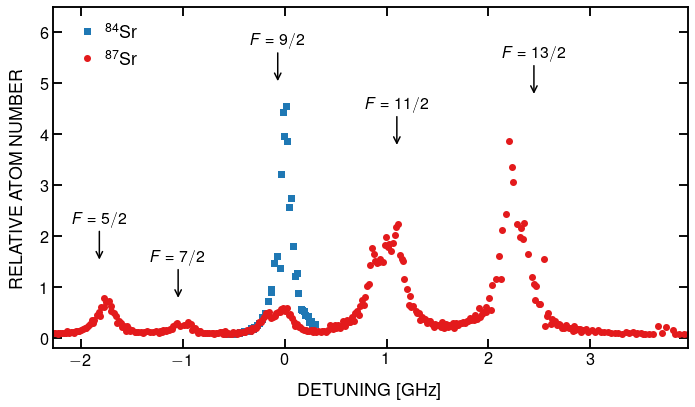

In [9]:
sns.set_context('talk')

marker_style_84Sr = {'markerfacecolor':sns.color_palette("Paired")[1],
                     'marker':'s',
                     'markersize':5,
                     'markeredgecolor':sns.color_palette("Paired")[1],
                     'markeredgewidth':2,
                     'linestyle':'None',
                     'zorder':1}

marker_style_87Sr = {'markerfacecolor':sns.color_palette("Paired")[5],
                     'marker':'o',
                     'markersize':5,
                     'markeredgecolor':sns.color_palette("Paired")[5],
                     'markeredgewidth':2,
                     'linestyle':'None',
                     'zorder':2}

arrowprops={'arrowstyle':'->'}

annotation_args = {'size':16}

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(x_84Sr, y_84Sr/1E6, **marker_style_84Sr, label=r'\textsuperscript{84}{Sr}')
ax.plot(x_87Sr, y_87Sr/1E6, **marker_style_87Sr, label=r'\textsuperscript{87}{Sr}')

Foffset = 0.55
F52 = -2.37122 + Foffset
F72 = -1.59714 + Foffset
F92 = -0.618691 + Foffset
F112 = 0.551517 + Foffset
F132 = 1.89808 + Foffset

ax.annotate(r'$F={5/2}$', xy=(F52,1.5), xytext=(F52,2.25), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F={7/2}$', xy=(F72,0.75), xytext=(F72,1.5), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F={9/2}$', xy=(F92,5), xytext=(F92,5.75), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F={11/2}$', xy=(F112,3.75), xytext=(F112,4.5), ha='center', arrowprops=arrowprops, **annotation_args)
ax.annotate(r'$F={13/2}$', xy=(F132,4.75), xytext=(F132,5.5), ha='center', arrowprops=arrowprops, **annotation_args)

# Tick params
ax.tick_params(which='both', axis='both', direction='in', top=True, right=True)

# Axis limits
ax.set_xlim((min(x_87Sr), max(x_87Sr)))
ax.set_ylim((-0.2, 6.5))

# Axis labels
ax.set_xlabel(r'DETUNING [\si{\GHz}]', labelpad=15)
ax.set_ylabel(r'RELATIVE ATOM NUMBER', labelpad=15)

# Legend
ax.legend(loc='upper left', handletextpad=0, frameon=False, fontsize=18)

# Display and save

plt.tight_layout()
plt.savefig('Fig3.pdf', bbox_inches='tight')

plt.show()